Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

## Data Preparation

In [ ]:
import numpy as np
import pandas as pd
import time
%matplotlib inline

#### Load data

This data set was taken from: http://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset
It contains ten numerical variables and eight categorical variables. The first six variables indicate the number of pages and duration spent on different types of pages associated with products. Bounce rate and exit rate are associated with each webpage (as opposed to user) while PageValues indicates average page value a user has visited before previous purchase.

In [2]:
df0 = pd.read_csv('../data/online_shoppers_intention.csv',low_memory=False)
df0.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


#### Clean data

In [3]:
df = df0.dropna()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


#### Convert categorical variables to dummy variables

In [4]:
df = pd.get_dummies(df,columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType'])
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,False,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,False,False,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,False,False,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,True,False,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Normalize data

In [5]:
from sklearn.preprocessing import normalize

Y = df['Revenue'].values
df = df.drop(columns=['Revenue'])
X = normalize(df)

#### Set up training/test sets

In [6]:
from sklearn.model_selection import train_test_split
X1, X2, Y1, Y2 = train_test_split(X, Y, test_size=0.1, random_state=0)

#### Data exploration

In [7]:
np.mean(Y)

0.15474452554744525

About 15% of visitors made a purchase so this will be used as a base when checking model performance. Models must achieve at least 85% accuracy to be adding value.

## MLP Model

#### Model Setup

In [8]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

#### Apply GridSearchCV

A combination of 10, 100 and 1000 layers will be applied over 1-3 layers with three cross-validation folds.

In [9]:
# Set parameter grid for GridSearchCV
from itertools import product
grid_values = {'hidden_layer_sizes': [x for x in product((10,100,1000),repeat=3)]}

In [11]:
# Run GridSearchCV
from sklearn.model_selection import GridSearchCV
start_time = time.time()
mlp_fit = GridSearchCV(mlp, param_grid = grid_values,cv=3,n_jobs=5).fit(X1, Y1)
print('MLP Grid Search took %s seconds' % (time.time() - start_time))

MLP Grid Search took 3490.9280359745026 seconds


Within this hyperparameter set, the best MLP configuration was a three layer perceptron with 1000, 10 and 10 neuron layers.

In [12]:
mlp_fit.best_params_

{'hidden_layer_sizes': (1000, 10, 10)}

In [68]:
from sklearn.model_selection import cross_val_score

mlp_score_train = cross_val_score(mlp_fit.best_estimator_, X1, Y1, cv=5, n_jobs=5)
print('MLP Training scores: ', mlp_score_train)

mlp_score_test = cross_val_score(mlp_fit.best_estimator_, X2, Y2, cv=5, n_jobs=5)
print('MLP Test scores: ', mlp_score_test)

print("R\u00b2 (training set): {0:0.5f} (+/- {1:0.5f})".format(mlp_score_train.mean(), mlp_score_train.std() * 2))
print("R\u00b2 (test set):     {0:0.5f} (+/- {1:0.5f})".format(mlp_score_test.mean(), mlp_score_test.std() * 2))

MLP Training scores:  [0.88558559 0.90495495 0.89139252 0.89860297 0.89634971]
MLP Test scores:  [0.85483871 0.89473684 0.86585366 0.86585366 0.89430894]
R² (training set): 0.89538 (+/- 0.01311)
R² (test set):     0.87512 (+/- 0.03269)


## Random Forest Model

#### Model Setup

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)

#### Apply GridSearchCV

A range of hyperparameters wil be applied with max_features ranging from 5-70 and max_depth from 1-10 with three cross-validation folds.

In [63]:
grid_values = {'max_features': range(5,70,5),'max_depth':range(1,10)}

In [64]:
start_time = time.time()
rf_fit = GridSearchCV(rf, param_grid = grid_values,cv=3,n_jobs=5).fit(X1, Y1)
print('Random Forest Grid Search took %s seconds' % (time.time() - start_time))

Random Forest Grid Search took 324.945681810379 seconds


Within this hyperparameter set, the best Random Forest parameters were max_features = 8 and max_depth = 8.

In [66]:
rf_fit.best_params_

{'max_depth': 8, 'max_features': 50}

In [69]:
rf_score_train = cross_val_score(rf_fit.best_estimator_, X1, Y1, cv=5, n_jobs=5)
print('Random Forest Training scores: ', rf_score_train)

rf_score_test = cross_val_score(rf_fit.best_estimator_, X2, Y2, cv=5, n_jobs=5)
print('Random Forest Test scores: ', rf_score_test)

print("R\u00b2 (training set): {0:0.5f} (+/- {1:0.5f})".format(rf_score_train.mean(), rf_score_train.std() * 2))
print("R\u00b2 (test set):     {0:0.5f} (+/- {1:0.5f})".format(rf_score_test.mean(), rf_score_test.std() * 2))

Random Forest Training scores:  [0.89684685 0.91441441 0.90265886 0.90130689 0.90265886]
Random Forest Test scores:  [0.86290323 0.91093117 0.88211382 0.88211382 0.89837398]
R² (training set): 0.90358 (+/- 0.01165)
R² (test set):     0.88729 (+/- 0.03262)


## Comparison

- Test scores for both MLP and random forest were slightly lower than the training scores but do not seem to suggest a high degree of overfitting as standard deviation within the five folds is not too wide.
- Despite over five times the combinations (140 vs. 27), random forest performed slightly better by about 0.008 with comparable standard deviation.

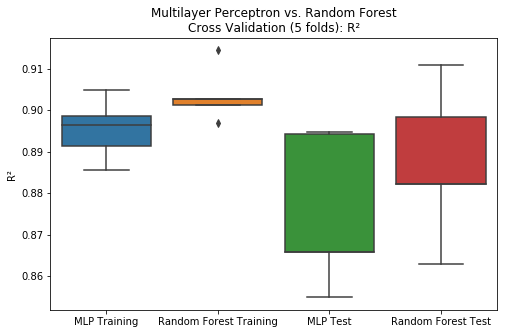

In [85]:
from matplotlib import pyplot as plt
import seaborn as sns

plot_DataFrame = pd.DataFrame(data={'MLP Training': mlp_score_train, 'Random Forest Training': rf_score_train, 
                                    'MLP Test': mlp_score_test, 'Random Forest Test': rf_score_test})

# Create boxplot comparing R^2 scores
plt.figure(figsize=(8,5))
sns.boxplot(data=plot_DataFrame)
plt.title('{}\nCross Validation ({} folds): R\u00b2'.format('Multilayer Perceptron vs. Random Forest',5))
plt.ylabel('R\u00b2')
plt.show()

- Random forest was about 10 times faster running at about five minutes compared to just under an hour.

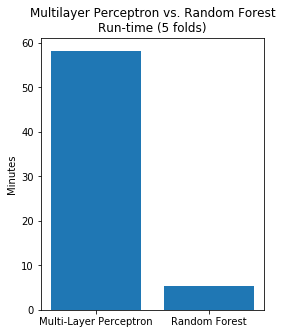

In [84]:
plot_DataFrame = pd.DataFrame(data={})

# Create boxplot comparing R^2 scores
plt.figure(figsize=(4,5))
plt.bar(np.arange(2),[ 3490.9/60, 324.9/60 ])
plt.title('{}\nRun-time ({} folds)'.format('Multilayer Perceptron vs. Random Forest',5))
plt.xticks(np.arange(2), ('Multi-Layer Perceptron','Random Forest'))
plt.ylabel('Minutes')
plt.show()

It's possible that MLP would outperform Random Forest using a different set of hyper-parameters but using the two sets chosen here, applying grid search, Random Forest outperformed. Considering the significant increase in run-time for MLP, additional tests would take quite a bit longer so these results will suffice for now.